In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
from fastai import *
from sklearn.metrics import roc_auc_score


# WARNING :
***THE NOTEBOOK MAY CONTAIN OBSCENE AND INAPPROPRIATE CONTENT BECAUSE OF THE NATURE OF THE DATASET BEING USED. READER DISCRETION IS ADVISED.***

# Language Model

## Preparing Data

In [2]:
# PATH = Path('data/Data_Processed/Data_Classifier').absolute()
PATH = Path('data/').absolute()

In [3]:
PATH.ls()

[PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/models'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/classifier_train_data'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/Data_Processed'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/kaggle_submission_1.csv'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/test_labels.csv'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/sample_submission.csv'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/train.csv'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/test.csv')]

For training the language model, we use both the `train` and `test` data. This is because the label for each word is the next word in the sequence and the test data can be used in this case. We ignore the classification labels and only use the column containing the text for the language model.

In [4]:
train = pd.DataFrame(pd.read_csv(PATH/'train.csv')['comment_text'])
test = pd.DataFrame(pd.read_csv(PATH/'test.csv')['comment_text'])
df_lm = train.append(test)

df_lm.head()

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."


In [58]:
bs = 48

In [60]:
data_lm = (TextList.from_df(train, path=PATH, cols='comment_text')
           .split_by_rand_pct(0.1)
           .label_for_lm()
           .databunch(bs=bs))

In [61]:
data_lm.show_batch()

idx,text
0,"background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ) xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about"
1,"\n face all sorts of physical and legal threats , both on- and off - wiki , as well as real - life stalking over prolonged periods by multiple people \n \n xxmaj all with little or no support from the xxup wmf and large swathes of the community who are more interested in the never - ending tendentious discussion of "" "" meta "" "" issues -"
2,"utc ) \n i think she xxunk the show and / or what callers are saying since xxmaj rush has a hearing problem , as you must well know . \n xxmaj plus she probably searches the web for current news in certain categories . 05:24 , 7 xxmaj march 2010 xxbos "" \n i 'd maintain it was only a personal attack , the user i"
3,\n person : xxup xxunk xxmaj global xxup ip - xxmaj addressing \n address : xxmaj deutsche xxmaj telekom xxup ag \n address : xxup xxunk xxmaj xxunk \n address : xxmaj germany \n phone : 49 180 xxunk \n fax - no : 49 180 xxunk \n e - mail : xxunk xxbos i liked it too and it inspired me to
4,"xxmaj german state ; xxmaj germany as an empire ( the xxmaj first xxmaj reich ) . . . and xxmaj third xxmaj reich as a dictatorship under the xxmaj nazi regime . . . ) "" xxbos xxmaj which one of us is having trouble with xxmaj wiki is not a xxmaj battlefield ? xxbos xxmaj thanks for clarifying . xxbos xxmaj this talk page is full of xxunk"


In [62]:
data_lm.save('tmp_lm_model')

In [185]:
data_lm = load_data(PATH, 'tmp_lm_model', bs=bs)

## Preparing the Language model

Here we load a pretrained model trained on the Wikitext 103 dataset.

In [186]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
def find_lr(model=learn):
    """
    Convenience function to perform learning rate range test and plot results.
    """
    model.lr_find()
    model.recorder.plot(skip_end=15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


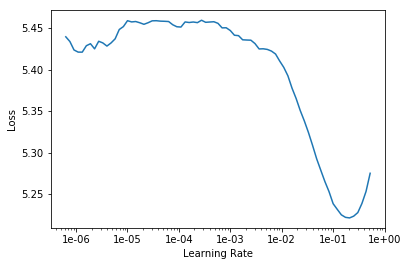

In [67]:
find_lr()

It looks like the loss is still decreasing steeply at a learning rate of about `3e-2`.

We first fit the head of the model before unfreezing it.

In [68]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.330651,4.091124,0.307680,12:01


In [69]:
learn.save('fit_head')

In [70]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (143614 items)
x: LMTextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " ty

In [71]:
learn.show_results()

text,target,pred
"xxbos would continue to be , delayed due to my xxup irl schedule . xxbos xxmaj get xxmaj well \n","\n xxmaj get well soon . ) xxbos "" \n \n xxmaj gerry xxmaj xxunk \n xxmaj","xxmaj hi the done , xxmaj xxmaj xxmaj \n \n xxmaj the xxmaj adams \n \n xxmaj hi"
"though , so please do nt delete cited factual information and i wo nt have to ... "" xxbos )",\n \n xxmaj for now i will leave your edit until i find proper sources to back myself .,"\n \n xxmaj the example , 've be a message to i can that references . be up ."
xxup rs now . if any editors can specify some content they believe should remain or possibly be merged to,"the fear mongering article , make your suggestions here . cheers xxbos xxup redirect xxmaj talk : xxmaj history of","the article of , , you sure own on . xxmaj . xxmaj redirect xxmaj talk : xxmaj xxunk of"
this great business . xxmaj it will be xxmaj wikipedia : wikiproject xxmaj music of wrestling . xxmaj join if,"you are remotely interested - every little helps ! xxmaj thanks . xxbos xxmaj of course i am sorry ,","you want interested related in xxmaj time welcome to xxmaj please . xxmaj xxmaj the course , am not ."
"you created , xxmaj xxunk xxmaj villa xxmaj xxunk xxmaj soccer xxmaj club , has been tagged for deletion ,","as it meets one or more of the criteria for speedy deletion ; specifically , it serves only to attack","and you is the of more of the criteria for speedy deletion . it , the is as as prevent"


**We will now unfreeze the whole model to fine tune al the weights for this particular dataset.**

In [105]:
learn.unfreeze()

In [107]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.805411,3.787183,0.341519,13:29
1,3.590235,3.664578,0.357810,13:30
2,3.558987,3.597754,0.366857,13:27
3,3.434307,3.562573,0.371835,13:27
4,3.357494,3.556864,0.372336,13:27


In [108]:
learn.save('fine_tuned')

In [109]:
learn.fit_one_cycle(5, 5e-4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.424021,3.561982,0.371912,13:28
1,3.436336,3.554538,0.372866,13:31
2,3.403637,3.539753,0.374899,13:28
3,3.341969,3.531037,0.376424,13:30
4,3.260996,3.532155,0.376360,13:27


In [110]:
learn.save('fine_tuned')

In [188]:
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (143614 items)
x: LMTextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " ty

In [158]:
print('\n'.join(learn.predict("I like to", n_words=15, temperature=0.75) for i in range(5)))

I like to see you return and look for you . The Red Pen of
I like to know what the hell have you done , but i did n't much of that
I like to be careful of the proper style of the British and Irish Isles
I like to incorporate some of the information into the article . In this case , the
I like to see how i can get a chance to respond . xxbos While i appreciate


As we can see, the model has somewhat of an understanding of grammar and of how an opinion is expressed.<br>
It also has an understanding of how possessive pronouns work.<br>
Also, the model seems to have learnt that the comments generally have a speaker that is expressing an opinion and that it is frequently addressed to some other people. This seems enough information to go forward with training the classifier.

The encoder of this model will be used to train a classifier on the dataset.

In [189]:
learn.save_encoder('fine_tuned_enc')

# Training the Classifier

## Preparing the classification dataset

In [2]:
PATH = Path('data/').absolute()

In [3]:
PATH.ls()

[PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/models'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/classifier_train_data'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/Data_Processed'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/test_labels.csv'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/sample_submission.csv'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/train.csv'),
 PosixPath('/home/akash/personal_projects/kaggle/ToxicComments/data/test.csv')]

In [52]:
df = pd.read_csv(PATH/'train.csv').drop('id', axis=1)

In [53]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
bs = 48

In [179]:
data_clas = (TextList.from_csv(path=PATH, csv_name='train.csv', cols='comment_text', vocab=data_lm.vocab)
            .split_by_rand_pct(0.1)
            .label_from_df(cols=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
            .databunch(bs=bs))
             

In [180]:
data_clas.show_batch()

text,target
xxbos xxmaj take that ! \n \n xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in xxup the xxup ass xxup in,toxic;severe_toxic;obscene
"xxbos "" \n \n xxmaj fourth xxmaj examination , 17th xxmaj december , 1455 . [ xxmaj additional statements . ] \n xxmaj the sum of a thousand pounds , or crowns , was given by the xxmaj king of xxmaj england for the surrender of the xxmaj maid ; and an annuity of 300 pounds to the soldier of the xxmaj duke of xxmaj burgundy who had",
"xxbos "" \n \n xxmaj sitush you are a menace to xxmaj wikipedia as this conversation from the page of another editor shows - xxmaj are you a 15 year old kid trying his hand in editing academic articles ? ? ? \n \n xxmaj first xxmaj xxunk xxmaj shastri writes to xxmaj jonathan . xxmaj this is because xxmaj sitush has just vandalized his article about xxmaj",
"xxbos xxmaj after all the times you have thwarted me ... xxmaj after all the times my plans for world domination were foiled by your xxunk interference ... xxmaj after all the countless times you escaped at the very last moment , finally , i , xxmaj xxunk xxmaj the xxmaj mighty , have defeated you , xxmaj crum375 , xxmaj space xxmaj commander xxmaj from xxmaj swalwell ! \n",toxic
"xxbos "" \n \n ( r to my favorite editor , started before xxmaj spotfixer commented : ) \n xxmaj not months , years . xxmaj he 'd been xxunk that shit on xxmaj shapiro since 2006 . xxmaj anyway , thanks for the kind words - coming from one in your time and place it 's especially touching that you 'd be aggrieved over my two week",


We save the data object because processing the dataset each time requires significant time.

In [181]:
data_clas.save('classifier_train_data')

In [6]:
data_clas = load_data(PATH, 'classifier_train_data', bs=bs)

## Preparing Model

In [8]:
# Reclaiming up some memory
learn = None
gc.collect()

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('../Data_Processed/Data_Classifier/models/fine_tuned_enc')

In [ ]:
def roc_score(model=learn):
    """
    Calculates the ROC score for all classes separately and returns their mean.
    """
    y_preds, y_true = learn.get_preds()
    return roc_auc_score(y_true.numpy(), y_preds.numpy(), average='macro')

This metric will classify as correct any prediction above `thresh = 0.4`.<br>
We will then simply calculate the accuracy taking into account each label as in the normal accuracy measure

In [9]:
acc = partial(accuracy_thresh, thresh=0.4)
learn.metrics.append(acc)

In [10]:
def find_lr(model=learn):
    """
    Convenience function to perform learning rate range test and plot results.
    """
    model.lr_find()
    model.recorder.plot(skip_end=15)

### Start Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


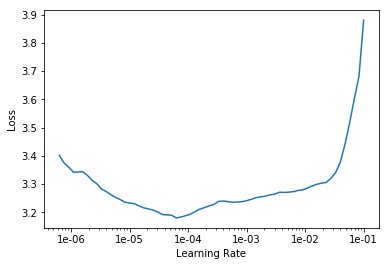

In [201]:
find_lr()

Although we can see that the loss is increasing as we go above a learning rate of, `1e-4` we will choose a learning rate of `1e-3` since that generally seems to work best when initially training a random set of weights at the head of a pretrained model.

In [202]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,time
0,0.073462,0.065989,04:13


In [203]:
learn.save('first')

In [204]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (143614 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

*We will now unfreeze and fine tune the last 2 layers instead of just the last layer.*

In [205]:
learn.freeze_to(-2)

In [206]:
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.072802,0.061296,05:32


In [236]:
learn.save('second')

In [237]:
learn.load('second')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (143614 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

In [233]:
learn.validate()

In [238]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),5e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.053653,0.054283,0.978756,09:50


In [239]:
learn.save('third')
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (143614 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

In [240]:
learn.predict("I will kill you. You are fat. Fuck off")

(MultiCategory toxic;severe_toxic;obscene;insult,
 tensor([1., 1., 1., 0., 1., 0.]),
 tensor([1.0000, 0.9644, 0.9999, 0.2910, 0.9989, 0.2105]))

We will now unfreeze the model and train it for a few epochs

In [241]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.055374,0.049385,0.980823,13:01
1,0.050902,0.047490,0.981314,11:02
2,0.050022,0.046927,0.981711,10:57


In [ ]:
learn.save('unfrozen_four')

In [10]:
learn.load('unfrozen_four')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (143614 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

In [243]:
learn.predict("I will kill you. You are fat. Fuck off")

(MultiCategory toxic;severe_toxic;obscene;threat;insult,
 tensor([1., 1., 1., 1., 1., 0.]),
 tensor([0.9999, 0.9392, 0.9997, 0.6798, 0.9904, 0.1193]))

In [254]:
learn.predict("I am gonna kick you")

(MultiCategory toxic;obscene;threat,
 tensor([1., 0., 1., 1., 0., 0.]),
 tensor([0.8747, 0.2716, 0.6994, 0.6640, 0.3426, 0.0494]))

In [31]:
roc_score()

0.9851895132990093

### Training a bit more

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


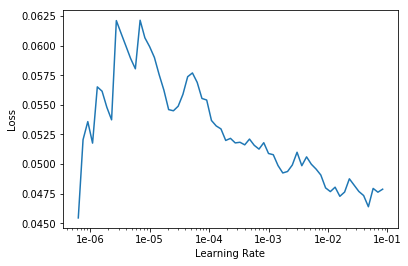

In [38]:
find_lr()

In [ ]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.053492,0.046831,0.980980,04:24
1,0.052653,0.046132,0.982369,04:00
2,0.052927,0.044149,0.982818,05:31
3,0.046456,0.044377,0.982432,04:49


In [45]:
learn.save('unfrozen_2')

In [11]:
learn.load('unfrozen_2')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (143614 items)
x: TextList
xxbos xxmaj explanation 
  xxmaj why the edits made under my username xxmaj hardcore xxmaj metallica xxmaj fan were reverted ? xxmaj they were n't vandalisms , just closure on some gas after i voted at xxmaj new xxmaj york xxmaj dolls xxup fac . xxmaj and please do n't remove the template from the talk page since i 'm retired xxunk,xxbos xxmaj xxunk ! xxmaj he matches this background colour i 'm seemingly stuck with . xxmaj thanks . ( talk ) 21:51 , xxmaj january 11 , 2016 ( xxup utc ),xxbos xxmaj hey man , i 'm really not trying to edit war . xxmaj it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page . xxmaj he seems to care more about the formatting than the actual info .,xxbos " 
  xxmaj more 
  i ca n't make any real suggestions on improvement - i wondered if the section statistics should be later on , or a subsection of " " types o

# Evaluating The Model

In [46]:
learn.show_results()

text,target,prediction
xxbos xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock d xxup suck xxup my xxup cock,toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult
xxbos xxup damn xxup you u xxup cunt xxup damn xxup you u xxup cunt xxup damn xxup you u xxup cunt xxup damn xxup you u xxup cunt xxup damn xxup you u xxup cunt xxup damn xxup you u xxup cunt xxup damn xxup you u xxup cunt xxup damn xxup you u xxup cunt xxup damn xxup you u xxup cunt xxup damn xxup you u xxup,toxic;severe_toxic;obscene;insult,toxic;severe_toxic;obscene;insult;identity_hate
xxbos do go fuck off bastard \n xxmaj do xxmaj yyou xxmaj have a life ? \n go fuck off bastard and yank your cock through your ass . i hate you and hope you go away forever . lame is you fuck your mom . die die die and all that crap . this is for xxunk xxunk \n ass . i ass . i ass,toxic;severe_toxic;obscene;threat;insult,toxic;severe_toxic;obscene;threat;insult
xxbos xxup shut xxup the xxup fuck xxup up ! \n xxup shut xxup the xxup fuck xxup up ! \n xxup shut xxup the xxup fuck xxup up ! \n xxup shut xxup the xxup fuck xxup up ! \n xxup shut xxup the xxup fuck xxup up ! \n xxup shut xxup the xxup fuck xxup up ! \n xxup shut xxup,toxic;severe_toxic;obscene,toxic;severe_toxic;obscene;insult
xxbos xxup wikipedia xxup loves xxup me . xxup they xxup like xxup to xxup censor xxup me . xxup communism xxup is xxup censorship . xxup wikipedia xxup is xxup communism . \n xxup wikipedia xxup loves xxup me . xxup they xxup like xxup to xxup censor xxup me . xxup communism xxup is xxup censorship . xxup wikipedia xxup is xxup communism . \n xxup,toxic;severe_toxic,toxic


In [47]:
roc_score()

0.9871003646219655

In [48]:
learn.validate()

[0.0441175, tensor(0.9826)]